In [ ]:
# Import all the needed packages

import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


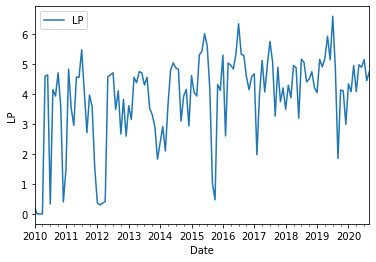

In [ ]:

# Load the data
data = pd.read_csv('LP2010-20 .csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['tgl']=pd.to_datetime(data['tgl'], format='%Y-%m-%d')
data.set_index(['tgl'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('LP')
plt.xlabel('Date')
plt.show()



In [ ]:
result = seasonal_decompose(data, 'multipicative')
result.plot()
plt.show()

ValueError: ignored

In [ ]:
# Determining if the time series is stationary or not
# Running dickey-fuller test on the time series 

result =adfuller(data['LP'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [ ]:
# From the above test we conclude the time series is non stationary. 
# Taking the first difference of time series and droping NaN values

data_diff = data.diff().dropna()
result_diff = adfuller(data_diff['LP'])
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

In [ ]:
# Plotting the time series after the first difference

data_diff.plot(figsize = (12,8), title = 'LP p')
plt.show()

In [ ]:
# Splitting the data into train and test set
x=data.values
data_train = x[:105]
data_test = x[105:]
len(data_test)

In [ ]:
# Finding AIC and BIC 
# Searching the model order with lowest AIC and BIC

import warnings
warnings.filterwarnings('ignore')
for p in range(5):
    
    for q in range(5):
        
        try:
            model = ARIMA(data_train, order = (p,1,q))
            fit_model = model.fit()
            
            print(p,q,fit_model.aic, fit_model.bic)
       
        except:
            print(p,q,None,None)

In [ ]:
# Fitting the ARIMA model into the train data set.
# Forecasting the next 60 months production 
model = ARIMA(data_train, order = (4,1,2))
fit_model = model.fit()
forecasted_data = fit_model.forecast(steps = 60)[0]
forecasted_data

In [ ]:
# Plotting the forecasted data with the actaul test data

plt.figure(figsize=(15,10))
plt.plot(forecasted_data, color='red', label = 'Forecasted')
plt.plot(data_test, color= 'blue', label = 'Observed')
plt.legend()
plt.show()


#SARIMA


In [ ]:
#!pip install pmdarima

In [ ]:
import pmdarima as pm

In [ ]:
# Run the function with the specified arguments to find the best model

sarima_model = pm.auto_arima(data, seasonal = True, m=12,d=1,D=1,start_p=1,start_q=1,start_P=0,max_p=3,max_q=3,
                             trace=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)

In [ ]:
# Fitting the model

sarima_model.fit(data_train)


In [ ]:
# Making the prediction based on the fitted SARIMA model

future_forecast = sarima_model.predict(n_periods=87)

In [ ]:
# Plotting the predicted data

plt.figure(figsize=(15,10))
plt.plot(future_forecast, color='red', label = 'Forecasted')
plt.plot(data_test,color='blue', label = 'Observed')
#plt.plot(data_train,color='green', label = 'train')
plt.legend()
plt.show()

#print(data_train)
#print(data_test)
#print(future_forecast)

In [ ]:
date = pd.date_range(start="2018-10-1",end="2025-12-31", freq='M')

In [ ]:
sarima_model.summary()

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame(future_forecast, columns=["ch"], index=date)

In [ ]:
# plotting the model diagnostics

sarima_model.plot_diagnostics(figsize=(12,8))
plt.show()

In [ ]:
def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import mean_squared_error

rms = mean_squared_error(data_test,future_forecast[:24], squared=False)
mape = MAPE(data_test,future_forecast[:24])
print("rms :",rms)
print("MAPE :",mape)

In [ ]:
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    #rms_error = np.round(rmse(y1, y2),1)
    
    #map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms, "%MAPE": mape}, ignore_index=True)
    
    return accuracy_df

accuracy(data_test,future_forecast[:24])